## Подключаем основные библиотеки

In [36]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

Загружаем датасет из предыдущего релиза

In [4]:
msk = pd.read_csv('../realises2/data.csv')

In [5]:
msk.head(1)

,id,number_of_rooms,metro,adress,apartment_area,house,parking,price_per_month,repair,balcony,windows,bathroom,child_or_animals,ceiling_height,elevator,garbage_chute
0,271271157,4,Рядом,"Москва, улица Новый Арбат, 27",200,"5/16, Монолитный",подземная,500000,Дизайнерский,"Балкон (0), Лоджия (0)",Во двор,Совмещенный (1),"Можно с детьми, Можно с животными",3.0,"Пасс (4), Груз (1)",Да


Удаляем адрес, так как нет возможности перевести его в числовой вид. Была идея, но не было времени...

In [6]:
msk.drop(['adress'], axis=1, inplace=True)

Разделяем колонку ДОМ на 2. Одна - тип дома, сделал с помощью регекса, мне очень нравится)

In [7]:
msk['house_type'] = msk['house'].str.extract(r',\s*([\w\s]+)$')

Вторая колонка - этажи. Тут, думаю, всё просто и понятно


In [8]:
def floors(val):
    part = val.split(',')
    if len(part) > 0:
        floor = part[0].strip()
        if '/' in floor:
            return floor
    return 0

msk['floor'] = msk['house'].apply(floors)

Удаляем изначальную колонку, зачем она нам??

In [9]:
msk.drop('house', axis=1, inplace=True)

In [10]:
msk['house_type'].value_counts().sum()

np.int64(15894)

In [11]:
msk['floor'].value_counts()

floor
3/5      524
4/5      511
2/5      481
5/5      433
5/9      393
        ... 
28/35      1
10/32      1
21/32      1
4/48       1
19/35      1
Name: count, Length: 884, dtype: int64

Переводим новые колонки в числовой вид. Идея какая, самые приятные для проживания этажи - те, что в середине. Отсюда и вывод, что для них нам нужно сделать что-то типа "нормального распределения". Ниже я написал эту функцию))) 

In [12]:
#преобразование floor к нормальному распределению. Чем центрее - тем лучше
def floors_to_norma(val):
    try:
        curr, vsego = map(int, val.split('/'))
        mid = vsego // 2

        if abs(curr - mid) <= 1:
            return 1
        elif curr == 1 or curr == vsego:
            return 0.2
        else:
            diff = abs(curr - mid)
            return max(0.2, 1 - (diff/mid))
    except ValueError:
        return 0
    
msk['floor'] = msk['floor'].apply(floors_to_norma)

Тут просто мапом переводим все полученные значения. Потом выяснится, что есть что-то ещё, их мы заполним просто средним значением

In [13]:
house_type = {
    'Панельный': 10,
    'Кирпичный': 12,
    'Монолитный': 9,
    'Блочный': 8,
    'Сталинский': 6,
    'старый фонд': 2, 
    'Деревянный': 1,
    'Щитовой': 1
}

msk['house_type'] = msk['house_type'].map(house_type)

In [14]:
msk['house_type'] = msk['house_type'].fillna(4)

In [15]:
msk['house_type'].isna().sum()

np.int64(0)

Смотрим, что у нас тут по лифтам. Задача - Разделить на 2 столбца (Грузовой и пассажирский) и в каждый занести значения из скобок. Если одного из лифтов нет - заполнить отсутствующее значение 0

In [16]:
msk['elevator'].value_counts()

elevator
Пасс (1)               9057
Пасс (2)               3997
Пасс (1), Груз (1)     3431
Пасс (2), Груз (1)     1091
Пасс (2), Груз (2)      606
Пасс (3)                545
Пасс (4)                307
Пасс (3), Груз (1)      170
Пасс (1), Груз (2)      168
Пасс (4), Груз (2)       60
Груз (1)                 57
Пасс (4), Груз (1)       55
Пасс (3), Груз (3)       42
Пасс (3), Груз (2)       36
Груз (4)                 25
Пасс (4), Груз (4)       23
Груз (2)                 18
Груз (3)                 15
Пасс (4), Груз (3)        7
Пасс (6)                  6
Пасс (1), Груз (3)        5
Пасс (60)                 2
Пасс (2), Груз (3)        2
Пасс (50)                 2
Пасс (1), Груз (12)       1
Пасс (5), Груз (1)        1
Пасс (8), Груз (8)        1
Пасс (7)                  1
Пасс (1), Груз (4)        1
Пасс (5), Груз (3)        1
Пасс (2), Груз (4)        1
Груз (6)                  1
Груз (8)                  1
Пасс (5)                  1
Name: count, dtype: int64

2 функции. Одна ищет и заполняет 

In [17]:
#Функция для пассажирских
def passanger(val):
    if val:
        if 'Пасс' in val:
            try:
                return int(val.split('Пасс (')[1].split(')')[0])
            except:
                return 0
    return 0

def gruz(val):
    if val:
        if 'Груз' in val:
            try:
                return int(val.split('Груз (')[1].split(')')[0])
            except:
                return 0
    return 0

msk['elevator_pass'] = msk['elevator'].apply(passanger)
msk['elevator_gruz'] = msk['elevator'].apply(gruz)

Удаляем Колонку лифтов за ненадобностью

In [18]:
msk.drop('elevator', axis=1, inplace=True)

Меняем значения в "Метро" и "мусоропроводе на числовые"

In [19]:
msk['metro'] = msk['metro'].str.contains('Рядом').astype(int)
msk['garbage_chute'] = msk['garbage_chute'].str.contains('Да').astype(int)

Для парковочных мест придумываем численные значения


In [20]:
mapping = {
    'наземная': 1,
    'подземная': 2,
    'открытая': 3,
    'многоуровневая': 4,
    'на крыше': 5
}

msk['parking'] = msk['parking'].map(mapping)

То же самое для ремонта. Без ремонта - плохо, а с ним уже лучше, но зависит от его типа

In [21]:
repair_apart = {
    'Без ремонта': 1,
    'Косметический': 2,
    'Евроремонт': 3,
    'Дизайнерский': 4
}
msk['repair'] = msk['repair'].map(repair_apart)

Также приводим к численному значению вид из окна. Мы решили, если во двор - то не очень хорошо, если на улицу, то лучше - допустим, там парк/лес/река и тд. Ну а если у нас сквозная квартира, то вообще отлично!

In [22]:
map_dwor = {
    'Во двор': 1,
    'На улицу и двор': 3,
    'На улицу': 2
}
msk['windows'] = msk['windows'].map(map_dwor)

Переводим балконы в числа! 


In [23]:
def balkon(val):
    if val:
        if 'Балкон' in val:
            try:
                return int(val.split('Балкон (')[1].split(')')[0])
            except:
                return 0
    return 0

def lodg(val):
    if val:
        if 'Лоджия' in val:
            try:
                return int(val.split('Лоджия (')[1].split(')')[0])
            except:
                return 0
    return 0

msk['balkon'] = msk['balcony'].apply(balkon)
msk['lodgy'] = msk['balcony'].apply(lodg)
msk.drop('balcony', axis=1, inplace=True)

И к нашим туалетам, конечно же!

In [24]:
msk['bathroom'].value_counts()

bathroom
Совмещенный (1)                    10541
Раздельный (1)                      6139
Совмещенный (2)                     1293
Совмещенный (1), Раздельный (1)      730
Раздельный (2)                       401
Совмещенный (3)                      223
Совмещенный (2), Раздельный (1)      179
Совмещенный (4)                       74
Раздельный (3)                        44
Совмещенный (1), Раздельный (2)       28
Совмещенный (3), Раздельный (1)       26
Совмещенный (2), Раздельный (2)       22
Раздельный (4)                        15
Совмещенный (3), Раздельный (3)        6
Совмещенный (4), Раздельный (1)        6
Совмещенный (4), Раздельный (2)        4
Совмещенный (2), Раздельный (3)        2
Совмещенный (1), Раздельный (3)        2
Совмещенный (2), Раздельный (4)        1
Совмещенный (3), Раздельный (2)        1
Name: count, dtype: int64

Делаем абсолютно то же самое, что и для балконов и лифтами

In [25]:
def toilet(val):
    if val:
        if 'Совмещенный' in val:
            try:
                return int(val.split('Совмещенный (')[1].split(')')[0])
            except:
                return 0
    return 0

def vanna(val):
    if val:
        if 'Раздельный' in val:
            try:
                return int(val.split('Раздельный (')[1].split(')')[0])
            except:
                return 0
    return 0

msk['sovm'] = msk['bathroom'].apply(toilet)
msk['razd'] = msk['bathroom'].apply(vanna)
msk.drop('bathroom', axis=1, inplace=True)

Изменяем значения для возможностей съема с кошкой/собакой

In [26]:
msk['child_or_animals'].value_counts()

map_child = {
    'Можно с детьми': 1,
    'Можно с детьми, Можно с животными': 3,
    'Не указано': 0,
    'Можно с животными': 2
}
msk['child_or_animals'] = msk['child_or_animals'].map(map_child)

Делаем таргет

In [27]:
msk['target'] = msk['price_per_month'].copy()
msk.drop(columns=['price_per_month'], axis=1, inplace=True)

Смотрим данные

In [28]:
msk.head(10)

,id,number_of_rooms,metro,apartment_area,parking,repair,windows,child_or_animals,ceiling_height,garbage_chute,house_type,floor,elevator_pass,elevator_gruz,balkon,lodgy,sovm,razd,target
0,271271157,4,1,200,2,4,1,3,3.00,1,9.0,0.625000,4,1,0,0,1,0,500000
1,271634126,4,1,198,2,4,3,1,3.50,0,4.0,0.625000,1,1,0,0,2,1,500000
2,271173086,4,1,200,2,3,3,1,3.20,0,4.0,0.625000,1,0,0,0,3,0,500000
3,272197456,4,1,170,2,3,3,2,3.20,0,4.0,0.333333,1,0,0,0,3,0,400000
4,273614615,2,1,58,1,3,3,0,3.90,1,10.0,1.000000,1,1,0,0,2,0,225000
5,274837728,3,1,92,1,4,1,0,2.76,0,4.0,1.000000,1,0,0,0,1,0,470000
6,273643908,5,1,213,1,3,3,3,3.20,0,4.0,0.200000,1,0,0,0,2,0,350000
7,274475342,3,1,98,2,3,1,3,3.20,0,9.0,1.000000,1,0,0,0,1,1,250000
8,273973191,3,1,120,3,3,2,2,3.00,0,6.0,1.000000,1,0,0,0,1,0,130000
9,272900409,4,1,90,3,3,3,1,2.76,1,6.0,1.000000,1,0,1,0,1,1,210000


Проверяем на наличие пропусков (ЧТОБЫ ТОЧНО)

In [29]:
msk.isna().sum()


id                  0
number_of_rooms     0
metro               0
apartment_area      0
parking             0
repair              0
windows             0
child_or_animals    0
ceiling_height      0
garbage_chute       0
house_type          0
floor               0
elevator_pass       0
elevator_gruz       0
balkon              0
lodgy               0
sovm                0
razd                0
target              0
dtype: int64

Удаляем дубликаты

In [30]:
msk = msk.drop_duplicates()

Выгружаем в файл

In [31]:
msk.to_csv('pylions.csv', index=False, encoding='utf-8')

Немного графичков!

In [33]:
msk.drop(columns=['id'], axis=1, inplace=True)

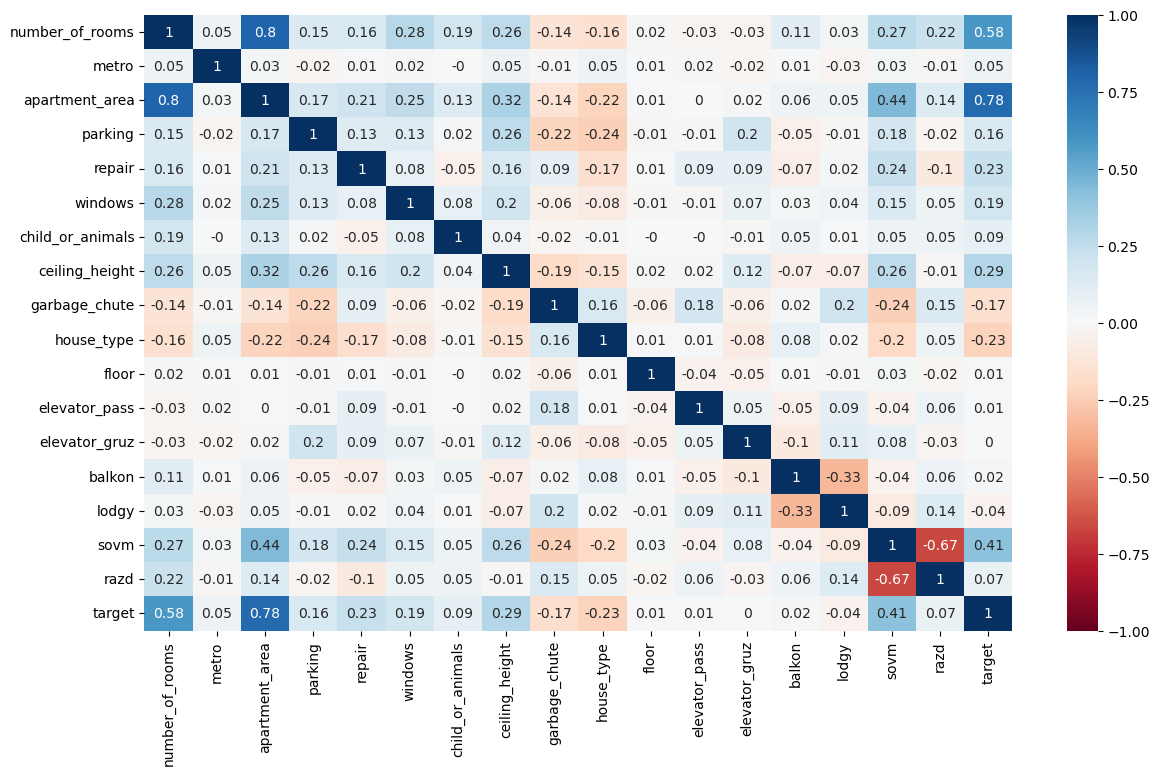

In [34]:
corr_matrix = msk.corr().round(2)
figl, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(corr_matrix, annot=True, cmap="RdBu", vmax=1, vmin=-1);

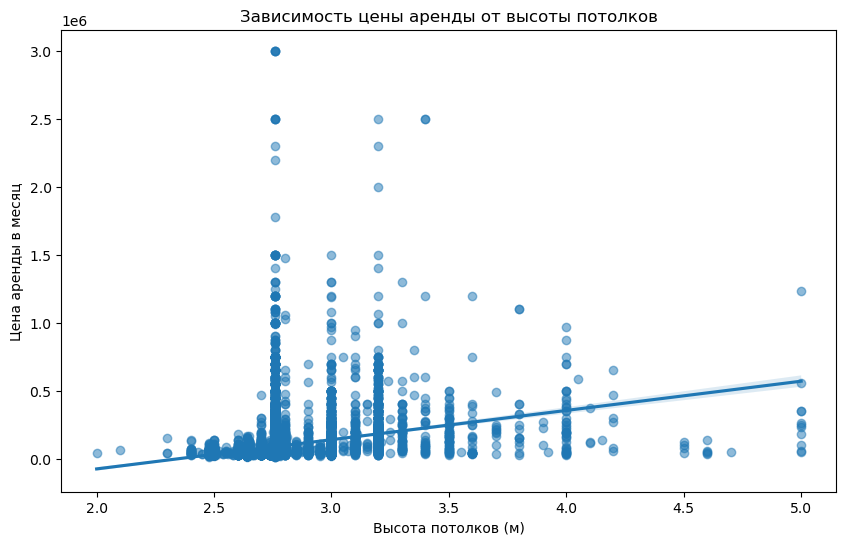

In [35]:
plt.figure(figsize=(10, 6))
sns.regplot(data=msk, x='ceiling_height', y='target', scatter_kws={'alpha':0.5})
plt.title('Зависимость цены аренды от высоты потолков')
plt.xlabel('Высота потолков (м)')
plt.ylabel('Цена аренды в месяц')
plt.show()

/tmp/ipykernel_1684346/68976505.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_price_by_rooms, x='number_of_rooms', y='target', palette='Set2', edgecolor='black')


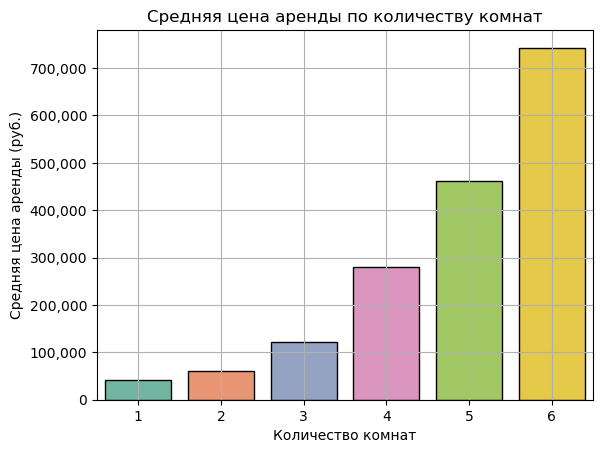

In [37]:
avg_price_by_rooms = msk.groupby('number_of_rooms')['target'].mean().reset_index()

sns.barplot(data=avg_price_by_rooms, x='number_of_rooms', y='target', palette='Set2', edgecolor='black')

ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

plt.title('Средняя цена аренды по количеству комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Средняя цена аренды (руб.)')
plt.grid(True)
plt.show()